In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch

import os

# data_path = '/Users/ruchiraravishankar/Downloads/iam_dataset/'
data_path = '/content/drive/MyDrive/iam_dataset/'
save_path = "/content/drive/MyDrive/iam_dataset/saved_model/"

# print(glob.glob(data_path))

In [ ]:
# toggles to change training and nodes

# set NODE to 2 or 3 or to reuse node 2 model on node 3, set to 23
NODE = 2
# NODE 23 only has plain_inf and fc settings, conv does not work
# transfer learning toggle
fc = False
conv = True
plain_inf = False


# toggle to save model
save_model = True
# toggle to save results
save_results = True

if plain_inf:
  save_model = False


In [ ]:
labelled_data = np.load(data_path + "labelled_data.npy")

In [ ]:
labelled_data_0 = labelled_data[labelled_data[:,1] == '000']

print(labelled_data_0.shape)
if NODE == 2:
  labelled_data_0 = labelled_data_0[196:(196*2)] # different set of data to the one that its originally trained on
elif NODE == 3 or NODE == 23:
  labelled_data_0 = labelled_data_0[(196*2):(196*3)] 
else:
  print("NODE not set")
print(labelled_data_0.shape)
print(np.unique(labelled_data_0[:,1]))

(693, 2)
(196, 2)
['000']


In [ ]:
remove_000 = labelled_data[labelled_data[:,1]!='000']

print(np.unique(remove_000[:,1]))
print(np.unique(remove_000[:,1]).shape)

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']
(49,)


In [ ]:
y = [remove_000[remove_000[:,1]==k] for k in np.unique(remove_000[:,1])]
print(len(y))

49


In [ ]:
labelled_data_1 = []
for i in y:
  if NODE == 2:
    labelled_data_1.append(i[5:9]) # different set of data to the one that its originally trained on
  elif NODE == 3 or NODE == 23:
    labelled_data_1.append(i[9:13])
  else:
    print("NODE not set")

print(len(labelled_data_1))

labelled_data_1 = np.array(labelled_data_1)

print(labelled_data_1.shape)

49
(49, 4, 2)


In [ ]:
labelled_data_1=labelled_data_1.reshape(-1,2)

In [ ]:
print(labelled_data_1.shape)

(196, 2)


<BarContainer object of 49 artists>

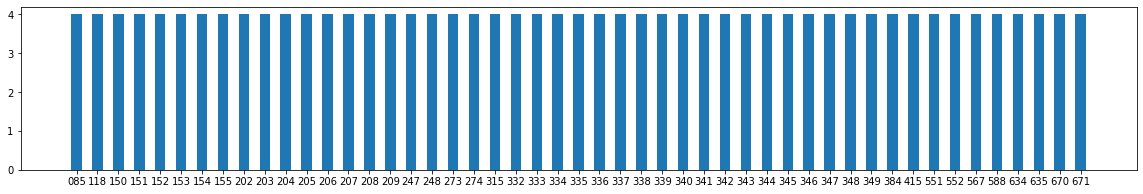

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
labelled_data_1_count = Counter(labelled_data_1[:,1])
plt.figure(figsize=(20,3))
plt.bar(labelled_data_1_count.keys(), labelled_data_1_count.values(), width=0.5)

<BarContainer object of 1 artists>

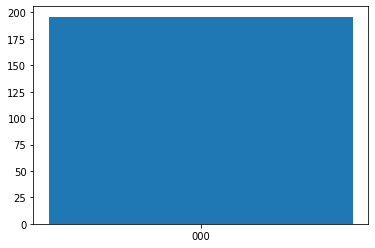

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,3))
labelled_data_0_count = Counter(labelled_data_0[:,1])
# plt.figure(figsize=(20,3))
plt.bar(labelled_data_0_count.keys(), labelled_data_0_count.values(), width=0.5)

In [ ]:
print(np.unique(labelled_data_1[:,1]))

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']


In [ ]:
labelled_data_new = np.concatenate((labelled_data_0, labelled_data_1))
np.random.shuffle(labelled_data_new)
print(labelled_data_new.shape) # mix of sentences from writer id 0 and others, labelled

(392, 2)


<BarContainer object of 2 artists>

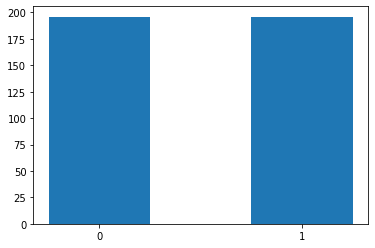

In [ ]:
class_counts = {'0':len(labelled_data_0),'1':len(labelled_data_1)}
plt.bar(class_counts.keys(), class_counts.values(), width=0.5)

In [ ]:
# split before augmenting to ensure the sentences are being split and not the augmented samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(labelled_data_new[:,0], labelled_data_new[:,1], test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(262,) (130,) (262,) (130,)


In [ ]:
from sklearn.utils import shuffle
from PIL import Image
import random

CROP_SIZE = 113
NUM_LABELS = 50

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return images, labels

In [ ]:
def augment(data, labels):
    augmented_sample_list = []
    augmented_label_list = []
    for i in range(len(data)):
        augmented_samples, augmented_labels = get_augmented_sample(data[i], labels[i],0.1)
        augmented_sample_list.append(augmented_samples)
        augmented_label_list.append(augmented_labels)
    return augmented_sample_list, augmented_label_list

In [ ]:
augsamps, auglbls = augment(X_train, y_train) # returns two lists of arrays
ausamps_test, auglbls_test = augment(X_test, y_test)

In [ ]:
import operator
from functools import reduce

# flattening the lists
aug_samps = reduce(operator.add, augsamps)
aug_lbls = reduce(operator.add, auglbls)

aug_samps_test = reduce(operator.add, ausamps_test)
aug_lbls_test = reduce(operator.add, auglbls_test)
print(len(aug_samps))
print(len(aug_lbls))

print(len(aug_samps_test))
print(len(aug_lbls_test))

42886
42886
22220
22220


In [ ]:
# converting lists to arrays
aug_samps_arr = np.array(aug_samps)
aug_lbls_arr = np.array(aug_lbls)
aug_samps_arr_test = np.array(aug_samps_test)
aug_lbls_arr_test = np.array(aug_lbls_test)

print(aug_samps_arr.shape)
print(aug_lbls_arr.shape)
print(aug_samps_arr_test.shape)
print(aug_lbls_arr_test.shape)

(42886, 113, 113)
(42886,)
(22220, 113, 113)
(22220,)


In [ ]:
def transform_data_aug_samps(data):
  data = data.reshape(data.shape[0], 1, CROP_SIZE, CROP_SIZE)
  data = data.astype('float16')
  data /= 255.0
  return data

In [ ]:
X_train = transform_data_aug_samps(aug_samps_arr)
X_test = transform_data_aug_samps(aug_samps_arr_test)

In [ ]:
def convert_y_labels(labels):
  new = np.unique(labels)
  print(new)

  labels[labels !='000'] = 1
  new = np.unique(labels)
  print(new)

  labels[labels=='000'] = 0
  new = np.unique(labels)
  print(new)

  print(labels.shape)

  labels = labels.astype('float16')

  print(np.unique(labels))
  return labels

In [ ]:
y_train = convert_y_labels(aug_lbls_arr)
y_test = convert_y_labels(aug_lbls_arr_test)


['000' '085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204'
 '205' '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333'
 '334' '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345'
 '346' '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635'
 '670' '671']
['000' '1']
['0' '1']
(42886,)
[0. 1.]
['000' '118' '150' '151' '152' '153' '155' '202' '205' '206' '207' '208'
 '209' '247' '248' '273' '315' '332' '333' '335' '336' '337' '338' '339'
 '340' '341' '342' '343' '345' '346' '347' '348' '349' '384' '415' '551'
 '552' '588' '634' '670' '671']
['000' '1']
['0' '1']
(22220,)
[0. 1.]


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42886, 1, 113, 113)
(42886,)
(22220, 1, 113, 113)
(22220,)


In [ ]:
print(y_test[y_test==1.0].shape)

(8006,)


In [ ]:
torch.manual_seed(42)
CUDA = torch.cuda.is_available()

device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

if CUDA:
  tensor_x_train = torch.Tensor(X_train).type(torch.cuda.FloatTensor) # transform to torch tensor
  tensor_y_train = torch.Tensor(y_train).type(torch.cuda.FloatTensor).long()
else:
  tensor_x_train = torch.Tensor(X_train).type(torch.FloatTensor) # transform to torch tensor
  tensor_y_train = torch.Tensor(y_train).type(torch.FloatTensor).long()

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
if CUDA:
  tensor_x_test = torch.Tensor(X_test).type(torch.cuda.FloatTensor) # transform to torch tensor
  tensor_y_test = torch.Tensor(y_test).type(torch.cuda.FloatTensor).long()
else:
  tensor_x_test = torch.Tensor(X_test).type(torch.FloatTensor) # transform to torch tensor
  tensor_y_test = torch.Tensor(y_test).type(torch.FloatTensor).long()

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True) # create your dataloader

In [ ]:
tensor_x_train.shape

torch.Size([42886, 1, 113, 113])

In [ ]:
from torch import nn
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super(Binary_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.fc1 = nn.Linear(4320, 1024)
        self.fc2 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2)
    def forward(self, x):
        x = self.relu(self.max_pool2d(self.conv1(x)))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv2(x))))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv3(x))))
        x = x.view(x.shape[0],-1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.conv_drop(x)
        x = self.fc2(x)
        return x

In [ ]:
model=Binary_Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

In [ ]:
if NODE == 23:
  model_path = 'model_tf_3_convs_retrain_last_conv_node2.pt'
else:
  model_path = 'model_3_convs.pt'


In [ ]:
try:
    print('Loading checkpoint: %s' % "/content/drive/MyDrive/iam_dataset/saved_model/" + model_path)
    path = torch.load( "/content/drive/MyDrive/iam_dataset/saved_model/"  + model_path)
    epoch = path['epoch']
    model.load_state_dict(path['model'])
    optimizer.load_state_dict(path['optimizer'])
except Exception as e:
  print("nothing happened")
  print(e)

Loading checkpoint: /content/drive/MyDrive/iam_dataset/saved_model/model_3_convs.pt


In [ ]:
print(model.parameters)

<bound method Module.parameters of Binary_Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4320, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>


In [ ]:
print(device)

cuda


In [ ]:
if fc or conv:
  for param in model.parameters():
    param.requires_grad = False

In [ ]:
if conv and NODE != 23:
  for param in model.conv3.parameters():
    param.requires_grad = True

In [ ]:
if fc or conv:
  num_ftrs = model.fc2.in_features
  print(num_ftrs)
  model.fc2 = nn.Linear(num_ftrs, 2).to(device)

1024


In [ ]:
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
True
True
False
False
True
True


In [ ]:
train_losses = []
train_loss_record = []

In [ ]:
from datetime import datetime
train_log_string = '%s :: Epoch %i :: Iter %i / %i :: train loss: %0.4f'
def train(epoch):
    print('Start Epoch {} Training...'.format(epoch))
    model.train()
    train_loss = []
    train_loss_sum = []
    for idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #  forward-pass
        output = model(data)
        loss = criterion(output, target)
        #backward-pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        train_loss.append(loss.data.cpu().numpy())
        train_loss_sum.append(loss)
        if ((idx +1) % 5000) == 0:
          print(train_log_string % (datetime.now(), epoch, idx + 1, len(train_dataloader), np.mean(train_loss)))
          train_loss = []
    mean_tr = torch.mean(torch.stack(train_loss_sum))
    print('Train Loss at epoch {}: {}\n'.format(epoch, mean_tr))
    train_loss_record.append(mean_tr)
    return train_loss_record

In [ ]:
# for epoch in range(15):
#     tlr = train(epoch)
import time
if fc or conv:
  train(1)
  torch.cuda.synchronize()

  times = []
  for epoch in range(15):
      start_epoch = time.time()
      tlr = train(epoch)
      torch.cuda.synchronize()
      end_epoch = time.time()
      elapsed = end_epoch - start_epoch
      times.append(elapsed)

  avg_time = sum(times)/15
  print(avg_time)

Start Epoch 1 Training...
Train Loss at epoch 1: 0.6816720366477966

Start Epoch 0 Training...
Train Loss at epoch 0: 0.6662664413452148

Start Epoch 1 Training...
Train Loss at epoch 1: 0.6572863459587097

Start Epoch 2 Training...
Train Loss at epoch 2: 0.6508752107620239

Start Epoch 3 Training...
Train Loss at epoch 3: 0.6501287221908569

Start Epoch 4 Training...
Train Loss at epoch 4: 0.6465754508972168

Start Epoch 5 Training...
Train Loss at epoch 5: 0.6423848867416382

Start Epoch 6 Training...
Train Loss at epoch 6: 0.640251100063324

Start Epoch 7 Training...
Train Loss at epoch 7: 0.6379615664482117

Start Epoch 8 Training...
Train Loss at epoch 8: 0.6372269988059998

Start Epoch 9 Training...
Train Loss at epoch 9: 0.6354622840881348

Start Epoch 10 Training...
Train Loss at epoch 10: 0.6350097060203552

Start Epoch 11 Training...
Train Loss at epoch 11: 0.6304542422294617

Start Epoch 12 Training...
Train Loss at epoch 12: 0.6297479867935181

Start Epoch 13 Training...
Tr

In [ ]:
# fc time 10.269379647572835
# conv time 17.83478244145711


(16,)


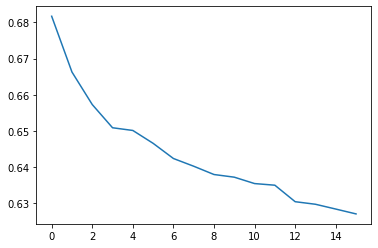

In [ ]:
import matplotlib.pyplot as plt
if fc or conv:
  temp = [t.detach().cpu().numpy() for t in tlr]
  arr = np.array(temp)
  print(arr.shape)

  plt.plot(arr)

In [ ]:
if save_model:
  state_dict = {
      'epoch': epoch,
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
  }
  if NODE == 2:
    if fc:
      torch.save(state_dict, save_path+'model_tf_3_convs_retrain_last_fc_node2.pt')
      print('Model saved!\n')
    elif conv:
      torch.save(state_dict, save_path+'model_tf_3_convs_retrain_last_conv_node2.pt')
      print('Model saved!\n')
    else:
      print("set NODE or fc/conv")
    
  elif NODE == 3:
    if fc:
      torch.save(state_dict, save_path+'model_tf_3_convs_retrain_last_fc_node3.pt')
      print('Model saved!\n')
    elif conv:
      torch.save(state_dict, save_path+'model_tf_3_convs_retrain_last_conv_node3.pt')
      print('Model saved!\n')
    else:
      print("set fc/conv")

  elif NODE == 23:
    torch.save(state_dict, save_path+'modelreuse_node2convmodel_retrainedfc_on_node3.pt')
    print('Model saved!\n')

  else:
      print("set NODE")

Model saved!



In [ ]:
result = []
prediction = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
        output = model(data)
        output_sm = nn.Softmax(dim=1)(output)
        _, predicted = torch.max(output, 1)
        prediction.append(predicted)
        result.append(output_sm)
        
result = torch.stack(result).detach().cpu().numpy()
prediction = torch.stack(prediction).detach().cpu().numpy()

print(result.shape, prediction.shape)

(1388, 16, 2) (1388, 16)


In [ ]:
print(prediction.reshape(-1).shape)

(22208,)


In [ ]:
import pandas as pd
res = pd.DataFrame(result.reshape(-1,2))
pred = pd.DataFrame(prediction.reshape(-1))

# res.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/results_transf_learn_3_convs_last_fc_retrain_2.csv", header=False, index=False)
# pred.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/pred_transf_learn_3_convs_last_fc_retrain_2.csv", header=False, index=False)

In [ ]:
print(res.shape, pred.shape)

(22208, 2) (22208, 1)


In [ ]:
y_test_new = y_test[:result.reshape(-1,2).shape[0]]

In [ ]:
print(y_test_new.shape)

(22208,)


In [ ]:
result_df = pd.DataFrame({'ground truth': y_test_new, 'NN output': prediction.reshape(-1), 'probs 0': res[0], 'probs 1': res[1]})
result_df

,ground truth,NN output,probs 0,probs 1
0,1.0,1,0.445766,0.554233
1,1.0,1,0.382056,0.617944
2,1.0,1,0.328117,0.671883
3,1.0,1,0.392546,0.607454
4,1.0,1,0.365969,0.634031
...,...,...,...,...
22203,0.0,0,0.566450,0.433549
22204,0.0,1,0.416568,0.583432
22205,0.0,1,0.461397,0.538603
22206,0.0,0,0.568451,0.431549


In [ ]:
# work out the accuracy and other metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
actual = result_df['ground truth']
predicted = result_df['NN output']
# confusion matrix
matrix = confusion_matrix(actual, predicted, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tn, fp, fn, tp = confusion_matrix(actual, predicted, labels=[0,1]).reshape(-1)
print('Outcome values : \n', tn, fp, fn, tp)

# tn, fp, fn, tp

# classification report for precision, recall f1-score and accuracy
matrix_2 = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix_2)

Confusion matrix : 
 [[10660  3542]
 [   12  7994]]
Outcome values : 
 10660 3542 12 7994
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.75      0.86     14202
           1       0.69      1.00      0.82      8006

    accuracy                           0.84     22208
   macro avg       0.85      0.87      0.84     22208
weighted avg       0.89      0.84      0.84     22208



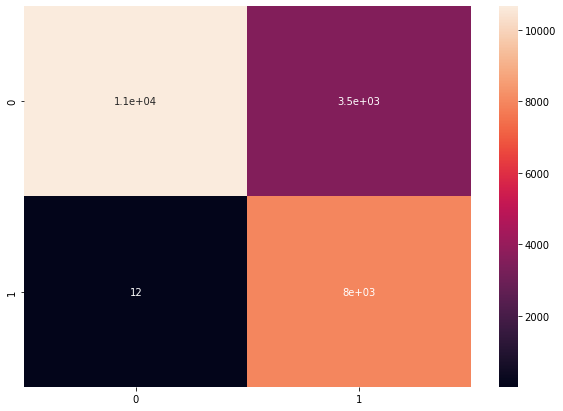

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
matrix_3 = classification_report(actual,predicted,labels=[0,1], output_dict=True)
print('Classification report : \n',matrix_3)
accuracy_score(actual, predicted)

Classification report : 
 {'0': {'precision': 0.9988755622188905, 'recall': 0.7505985072524997, 'f1-score': 0.8571198842164509, 'support': 14202}, '1': {'precision': 0.6929611650485437, 'recall': 0.9985011241568823, 'f1-score': 0.8181352983317981, 'support': 8006}, 'accuracy': 0.8399675792507204, 'macro avg': {'precision': 0.8459183636337171, 'recall': 0.8745498157046909, 'f1-score': 0.8376275912741245, 'support': 22208}, 'weighted avg': {'precision': 0.8885932016395589, 'recall': 0.8399675792507204, 'f1-score': 0.843065912918156, 'support': 22208}}


0.8399675792507204

In [ ]:
matrix_df = pd.DataFrame(matrix).transpose()
matrix_3_df = pd.DataFrame(matrix_3).transpose()

# matrix_df.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/conf_matrix_transf_learn_3_convs_last_fc_retrain_2.csv", header=False, index=False)
if save_results:
  if NODE == 2:
    if fc:
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_3_convs_last_fc_retrain_node2.csv", header=True, index=True)

    elif conv:
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_3_convs_last_conv_retrain_node2.csv", header=True, index=True)
    
    elif plain_inf:
      matrix_3_df.to_csv(save_path + "classification_report_conv_3_node2_pi.csv", header=True, index=True)

    else:
      print("set NODE or fc/conv/plain_inf")
    
  elif NODE == 3:
    if fc:
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_3_convs_last_fc_retrain_node3.csv", header=True, index=True)

    elif conv:
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_3_convs_last_conv_retrain_node3.csv", header=True, index=True)

    elif plain_inf:
      matrix_3_df.to_csv(save_path + "classification_report_conv_3_node3_pi.csv", header=True, index=True)
    
    else:
      print("set fc/conv/plain_inf")

  elif NODE == 23:
      if fc:
        matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node2convmodel_retrainedfc_on_node3.csv", header=True, index=True)
      elif conv:
        print("No conv option for this setting")
      elif plain_inf:
        matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node2convmodel_pi_on_node3.csv", header=True, index=True)
      else:
        print("set fc/conv/plain_inf")
  
  else:
      print("set NODE")
# pd.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/classification_report.txt",matrix)
